In [1]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
from numba import jit, njit, prange
from quantecon.util import tic, toc

In [2]:
@njit
def u(c, ceta = 2):
    return (c**(1 - ceta))/(1 -ceta)

In [13]:
class HH:
    
    def __init__(self,
                 r=0.01,                      # interest rate
                 w=1.0,                       # wages
                 cbeta=0.96,                  # discount factor
                 a_min=-5.0,
                 P=[[0.9, 0.1], [0.1, 0.9]],  # Markov chain
                 z_vals=[0.1, 1.0],           # exogenous states
                 a_max=18.0,
                 a_size=200,
                 ctheta = 0.03
                 ):
        
        #making all options class objects
        self.r, self.w, self.cbeta, self.ctheta = r, w, cbeta, ctheta
        self.a_min, self.a_max, self.a_size = a_min, a_max, a_size
        self.P, self.z_vals = np.asarray(P), np.asarray(z_vals)
        self.z_size = len(z_vals)
        
        self.a_grid = np.linspace(a_min, a_max, a_size)
    
    def pack_params(self):
        return self.r, self.w, self.cbeta, self.ctheta, self.a_min, self.a_max, self.a_size, self.P, self.z_vals, self.a_grid
        
    def bellman_operator(self):
        
        r, w, cbeta, ctheta, a_min, a_max, a_size, P, z_vals, a_grid = self.pack_params()
                                 
        @njit
        def T(v, v_out, pol):
            n, m = v.shape

            for j in prange(m):
                z = z_vals[j]

                for i in range(n):
                    x = a_grid[i]
                    # Cash in hand at start of period
                    if x < 0:
                        y = (1.0 + r - ctheta) * x + w * z
                    if x >= 0:
                        y = (1.0 + r) * x + w * z
                    max_so_far = - np.inf
                    # Find largest x_grid index s.t. x' <= y
                    idx = np.searchsorted(a_grid, y)
                    # Step through x' with 0 <= x' <= y, find max
                    for k in range(idx):
                        x_next = a_grid[k]
                        val = u(y - x_next) + cbeta * np.sum(v[k, :] * P[j, :])
                        if val > max_so_far:
                            max_so_far = val
                            a_star = k

                    pol[i, j] = a_star
                    v_out[i, j] = max_so_far
                    

        return T

In [14]:
@njit
def vfi(T, v_init, tol=1e-4, max_iter=1000):

    # Set initial condition, set up storage
    v_in = v_init
    v_out = np.empty_like(v_in)
    pol = np.empty_like(v_in, dtype=np.int_)
    # Set up loop
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        T(v_in, v_out, pol)
        error = np.max(np.abs(v_in - v_out))
        i += 1
        v_in[:] = v_out
    return v_out, pol

In [15]:
mod = HH(ctheta = 0)
T = mod.bellman_operator()
v_init = np.ones((mod.a_size, mod.z_size))

# warming up
v_star, pol = vfi(T, v_init, max_iter=1)

In [17]:
tic()
v_star, pol = vfi(T, v_init)
toc()

TOC: Elapsed: 0:00:0.00


0.0

In [27]:
@njit(parallel=True)
def simulate_stationary_assets(pol, 
                               P, 
                               a_grid, 
                               i_init=10, 
                               j_init=0, 
                               num_households=100_000,
                               ts_length=1000):
    asset_vals = np.empty(num_households)
    for m in range(num_households):
        i = i_init
        j = j_init

        for t in range(ts_length-1):
            i = pol[i, j]
            j = qe.random.draw(np.cumsum(P[j, :]))
            
        asset_vals[m] = a_grid[i]
        
    return asset_vals

tmp = simulate_stationary_assets(pol,mod.P, mod.a_grid,num_households=1, ts_length=1000)

In [29]:
tic()
asset_vals = simulate_stationary_assets(pol,mod.P, mod.a_grid)
toc()

TOC: Elapsed: 0:00:15.36


15.360820293426514

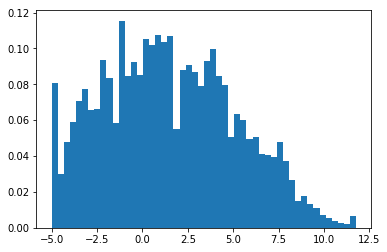

In [30]:
fig, ax = plt.subplots()
ax.hist(asset_vals, bins = 50, density=True)
plt.show()